In [2]:
import datetime
import matplotlib.pyplot as plt
import glob, cv2, random, os
import seaborn as sns
import pandas as pd
import numpy as np

from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.models import load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Preprocessing

## Load data

In [3]:
eye = pd.read_csv('dataset/dataset.csv')
eye.head()

,state,image
0,open,"[178, 179, 181, 180, 175, 171, 170, 168, 162, ..."
1,open,"[67, 66, 65, 64, 62, 62, 61, 61, 60, 61, 61, 5..."
2,open,"[80, 84, 90, 94, 97, 100, 103, 107, 108, 112, ..."
3,open,"[83, 81, 80, 81, 82, 81, 79, 78, 79, 80, 81, 7..."
4,close,"[121, 126, 131, 136, 140, 144, 146, 146, 151, ..."


## Extract feature and label from dataset

In [4]:
X = np.empty((len(eye), 26, 34, 1), dtype=np.uint8)
y = np.empty((len(eye), 1))
             
images = eye['image']
tags = eye['state']
for i in range(len(eye)):
    # array to image format
    image = images[i].strip('[').strip(']').split(', ')
    im = np.array(image, dtype=np.uint8)
    im = im.reshape((26, 34))  # height, width
    im = np.expand_dims(im, axis=2)
    X[i] = im
    
    # open: 1, close: 0
    if tags[i] == 'open':
        y[i] = 1
    else:
        y[i] = 0

In [5]:
print(X.shape, y.shape)

(2874, 26, 34, 1) (2874, 1)


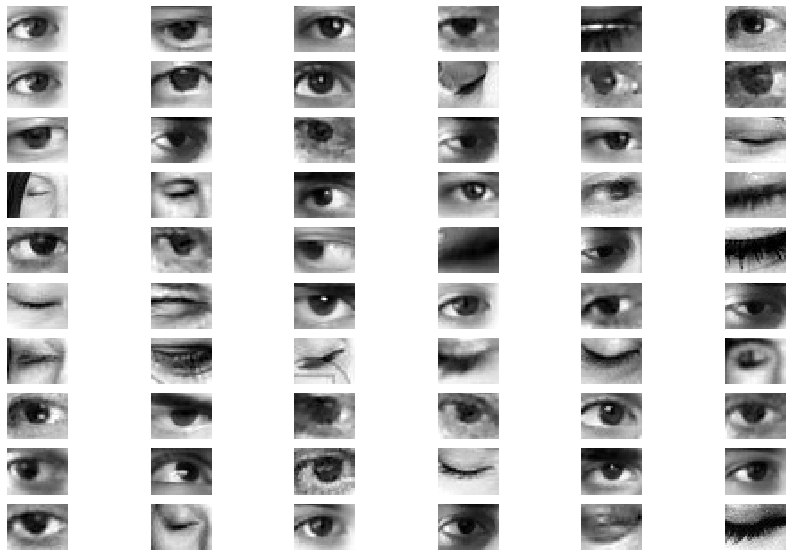

In [6]:
plt.figure(figsize=(15, 10))
for i in range(60):
    plt.subplot(10, 6, i+1)
    plt.axis('off')
    plt.imshow(X[i].reshape((26, 34)), cmap='gray')

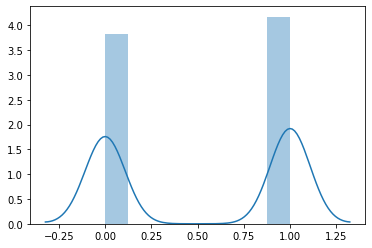

In [7]:
sns.distplot(y)

> open과 close 비율이 비슷한 것을 확인 가능하다

## Split Data for Train and Test

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


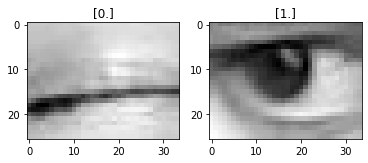

In [9]:
plt.subplot(1, 2, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(1, 2, 2)
plt.title(str(y_val[6]))
plt.imshow(x_val[6].reshape((26, 34)), cmap='gray')

## Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

# Train

## Build Model

In [11]:
model = Sequential([
    Conv2D(64, 7, activation='relu', padding='same', input_shape=[26, 34, 1]),
    MaxPooling2D(2),
    
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(2),
    
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(2),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 34, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 17, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 8, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 8, 256)         5

##  Model Train

In [12]:
start_time = datetime.datetime.now().strftime('%H_%M_%S')

model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[
        ModelCheckpoint('model/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05),
        EarlyStopping(monitor='val_acc', mode='max', patience=20, verbose=1)
    ]
)

C:\Users\chaey\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
81/81 [==============================] - 10s 113ms/step - loss: 0.6603 - acc: 0.5686 - val_loss: 0.4427 - val_acc: 0.8299

Epoch 00001: val_acc improved from -inf to 0.82986, saving model to model\20_43_20.h5
Epoch 2/50
81/81 [==============================] - 10s 120ms/step - loss: 0.4906 - acc: 0.7966 - val_loss: 0.4028 - val_acc: 0.8264

Epoch 00002: val_acc did not improve from 0.82986
Epoch 3/50
81/81 [==============================] - 11s 136ms/step - loss: 0.4415 - acc: 0.8338 - val_loss: 0.2636 - val_acc: 0.8993

Epoch 00003: val_acc improved from 0.82986 to 0.89931, saving model to model\20_43_20.h5
Epoch 4/50
81/81 [==============================] - 12s 145ms/step - loss: 0.4078 - acc: 0.8381 - val_loss: 0.3013 - val_acc: 0.8681

Epoch 00004: val_acc did not improve from 0.89931
Epoch 5/50
81/81 [==============================] - 11s 141ms/step - loss: 0.3026 - acc: 0.8891 - val_loss: 0.1418 - val_acc: 0.9549

Epoch 00005: val_acc improved from 0.89931 to 0.95486, 


Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
81/81 [==============================] - 17s 210ms/step - loss: 0.0171 - acc: 0.9945 - val_loss: 0.0029 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
81/81 [==============================] - 15s 191ms/step - loss: 0.0089 - acc: 0.9970 - val_loss: 0.0033 - val_acc: 0.9965

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
81/81 [==============================] - 15s 188ms/step - loss: 0.0157 - acc: 0.9960 - val_loss: 0.0036 - val_acc: 0.9965

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
81/81 [==============================] - 16s 199ms/step - loss: 0.0108 - acc: 0.9970 - val_loss: 0.0018 - val_acc: 1.0000

Epoch 00046: val_acc did not improve from 1.00000
Epoch 47/50
81/81 [==============================] - 17s 206ms/step - loss: 0.0192 - acc: 0.9952 - val_loss: 0.0039 - val_acc: 0.9965

Epoch 00047: val_acc did not improve from 1.00000
Epoch 48/50
81/81 [=====

> val_acc가 100%인 20_43_20.h5 모델 생성

test acc: 1.0


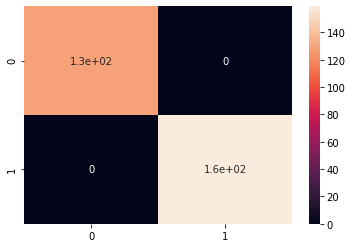

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('model/20_43_20.h5')

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

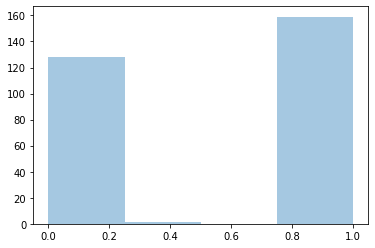

In [15]:
ax = sns.distplot(y_pred, kde=False)